## Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 4

This example plots an area, like in examples 2 and 3, and then calculates vegetation and snow cover.

**Note:** This example requires data for both True Color and False Color. We get these via two separate calls to the GSKY server.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.
    -- where an area around a single point is calculated.

- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.

- The required area is specified a tile from a list that shows the bounding boxes. 

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 14 January 2020

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox). Instead of manually typing in the BBox, you can select a tile by its ID (e.g. 8_-31).

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment its code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use, where i = 0 to n_times-1.

- Identify the tile ID in cell 4

- Specify the tile ID in cell 5
    - If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
        - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 14/01/2020  #
##########################################################

from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import logging, sys
logging.disable(sys.maxsize)


#### Specify the GSKY capabilities end URL is below. It must be one that you can access. 

Normally there are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers.

NOTE: The the production GSKY server does not output the 'nir', 'swir1' and 'swir2' bands. In order to provide this data, this notebook uses a development version of GSKY on the VMs. It will not work unless you are within the NCI network or connected to the NCI network via VPN.

In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

#### A time slice must be specified to show the layer. 

To help identify a time slice, specify the start and end values as m,n below, which will show the time slices in that range. Then specify the time slice as 't = i', where i = 0 to n_times-1

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times
# print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# The time slice whose data is to be displayed is specified below. 
t = n_times-1

#### The Australian continent is divided into approximately 1x1 degree tiles, from -22 to +27 longitude degrees from a line through the centre of Australia.

The ID and BBox for each tile will be generated in the next box. Choose a tile by its ID to display the layer.

In [4]:
tiles_list = {}
with open("Scripts/tiles_bboxes_out.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

#### You must select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time.

In [5]:
tiles = ['8_-31']
bbox = [tiles_list[tiles[0]]]
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 340)))
bbox = (x,y,X,Y)

# If you know a BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ('130.00,-27.00,131.00,-29.00')

bbox

(140.2, -27.36, 141.67, -28.31)

### Construct the GSKY end point URL

The GSKY capability endpoint URL is constructed below. You must specify a style ('fc' or 'tc'). 

#### DO NOT write the data into a file

The GSKY server returns the data in NetCDF format which is read into the variable, nc, in memory. It is NOT written to the disk.

In [6]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
print(output.geturl())


http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=140.2%2C-27.36%2C141.67%2C-28.31&time=2019-09-12T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tc


### Stack the True Color bands together and plot it
To plot the bands together, as in the case of Xarray, it is necessary to stack them using numpy. 

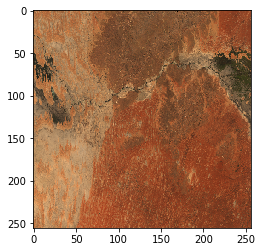

In [7]:
r = nc.variables['Band1'][:]
g = nc.variables['Band2'][:]
b = nc.variables['Band3'][:]

# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
rgb = np.stack([r, g, b], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment next line to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()


### The plot below is from the three "False Color" bands, 'nir', 'swir1' and 'swir2'

In [8]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
print(output.geturl())


http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=140.2%2C-27.36%2C141.67%2C-28.31&time=2019-09-12T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=fc


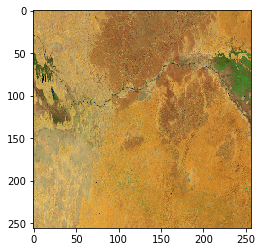

In [9]:
s1 = nc.variables['Band1'][:]
n = nc.variables['Band2'][:]
g = nc.variables['Band3'][:]
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
s1ng = np.stack([s1, n, g], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
s1ng /= s1ng.max()

# Uncomment next line to see the data values.
# print(s1ng)

# Plot it
imgplot = plt.imshow(s1ng)
plt.show()

### Compute Normalised Difference Snow Index (NDSI)

<function matplotlib.pyplot.show(*args, **kw)>

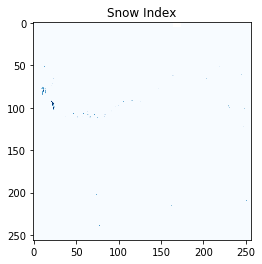

In [10]:
# Compute index by subtracting, summing and dividing the `green` and `swir1` bands
ndsi_ds = (g - s1) / (g + s1)

# Plot one sample timestep from the NDSI dataset
plt.imshow(ndsi_ds, cmap='Blues', interpolation = 'sinc', vmin = 0, vmax = 1)
plt.title('Snow Index')
plt.show

### Compute Normalised Difference Vegetation Index (NDVI)

<function matplotlib.pyplot.show(*args, **kw)>

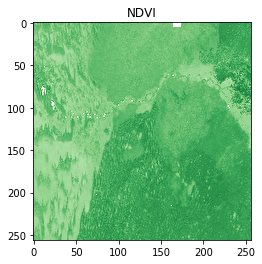

In [11]:
# Compute index by subtracting, summing and dividing the `nir` and `red` bands
ndvi_ds = (n - b) / (n + b)

# Plot one sample timestep from the NDSI dataset. Bright green values below
# represent growing green vegetation
plt.imshow(ndvi_ds, cmap='Greens', interpolation = 'sinc', vmin = 0, vmax = 1)
plt.title('NDVI')
plt.show

### Threshold NDSI and NDVI to identify snowy, non-vegetated pixels

Note: If the chosen area does not have snow cover, the plot below will be solid blue.

<function matplotlib.pyplot.show(*args, **kw)>

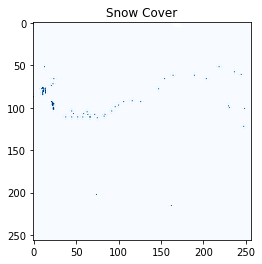

In [12]:
# Threshold that will be applied to the NDSI layer to identify pixels containing snow
ndsi_threshold = 0

# Threshold that will be applied to the NDVI layer to identify pixels containg vegetation
ndvi_threshold = 0.3

# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ndsi_ds > ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds < ndvi_threshold

# Finally, keep only pixels that are both snowy AND non-vegetated:
snow_ds = noveg_ds & noveg_ds

# Plot the resulting layer
plt.imshow(snow_ds, cmap='Blues', interpolation = 'sinc', vmin = 0, vmax = 1)
plt.title('Snow Cover')
plt.show

`Copyright` &copy; `2019 by National Computational Infrastructure (NCI).`